Saving Dataset_completo.csv to Dataset_completo.csv
🎯 Features seleccionados: ['MFCC_1', 'MFCC_2', 'MFCC_3', 'MFCC_4', 'MFCC_5', 'MFCC_6', 'MFCC_7', 'MFCC_9', 'MFCC_10', 'MFCC_11', 'MFCC_12', 'MFCC_13', 'f0', 'Centroid', 'ZCR', 'spectral_rolloff', 'spectral_flatness', 'crest_factor', 'spectral_bandwidth', 'rms_energy', 'delta_mfccs']

 Reporte de Clasificación (Test):
              precision    recall  f1-score   support

           f       0.94      0.94      0.94        16
          mf       0.78      0.88      0.82        16
           p       0.93      0.82      0.88        17

    accuracy                           0.88        49
   macro avg       0.88      0.88      0.88        49
weighted avg       0.88      0.88      0.88        49



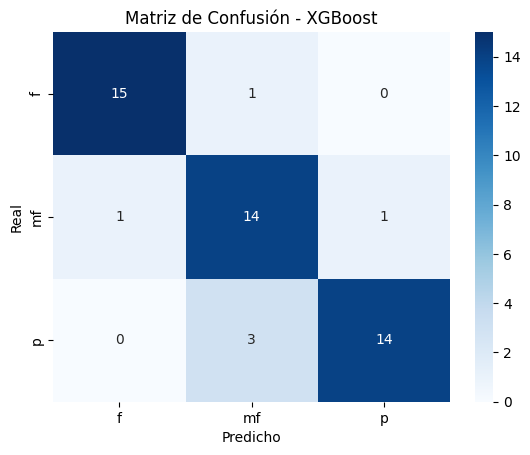


📈 Accuracy promedio (5-fold): 0.85 ± 0.03


In [1]:
# === 0. Subir CSV ===
from google.colab import files
uploaded = files.upload()

# === 1. Librerías ===
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import SelectKBest, f_classif

from xgboost import XGBClassifier

# === 2. Cargar dataset ===
file_name = list(uploaded.keys())[0]
df = pd.read_csv(file_name)

# === 3. Separar features y target ===
X = df.drop(columns=[
    "id_archivo", "nota", "octava", "simbolo_dinamica",
    "nombre_dinamica", "version", "clasificacion_duracion",
    "observacion_tecnica"
])
y = df["simbolo_dinamica"]

# === 4. Codificar etiquetas (p, mf, f → 0, 1, 2)
le = LabelEncoder()
y_encoded = le.fit_transform(y)  # etiquetas como [0, 1, 2]
class_names = le.classes_        # ['f', 'mf', 'p']

# === 5. Selección de 21 mejores features con escalado ===
pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("select", SelectKBest(score_func=f_classif, k=21))
])

X_selected = pipeline.fit_transform(X, y_encoded)
selected_features = X.columns[pipeline.named_steps["select"].get_support()]
X_final = df[selected_features]

print("🎯 Features seleccionados:", list(selected_features))

# === 6. Separar train/test ===
X_train, X_test, y_train, y_test = train_test_split(
    X_final, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# === 7. Entrenar y evaluar XGBoost ===
clf_xgb = XGBClassifier(
    objective='multi:softmax',
    num_class=3,
    eval_metric='mlogloss',
    random_state=42
)

clf_xgb.fit(X_train, y_train)
y_pred = clf_xgb.predict(X_test)

# === 8. Reporte de clasificación ===
print("\n Reporte de Clasificación (Test):")
print(classification_report(y_test, y_pred, target_names=class_names))

# === 9. Matriz de confusión ===
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.title("Matriz de Confusión - XGBoost")
plt.xlabel("Predicho")
plt.ylabel("Real")
plt.show()

# === 10. Validación cruzada estratificada ===
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(clf_xgb, X_final, y_encoded, cv=cv, scoring="accuracy")

print(f"\n📈 Accuracy promedio (5-fold): {scores.mean():.2f} ± {scores.std():.2f}")

# === 11. Importancia de features ===
clf_xgb.fit(X_final, y_encoded)
importancias = clf_xgb.feature_importances_

df_importancias = pd.DataFrame({
    "Feature": selected_features,
    "Importancia": importancias
}).sort_values(by="Importancia", ascending=False)

